In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
import re
from nltk.corpus import stopwords 
from bs4 import BeautifulSoup

In [2]:
data=pd.read_csv("G:/kaggle/Quora classification/train.csv")

In [3]:
data.shape

(1306122, 3)

In [4]:
data=data.drop('qid',axis=1)
data.head(10)

,question_text,target
0,How did Quebec nationalists see their province...,0
1,"Do you have an adopted dog, how would you enco...",0
2,Why does velocity affect time? Does velocity a...,0
3,How did Otto von Guericke used the Magdeburg h...,0
4,Can I convert montra helicon D to a mountain b...,0
5,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,Why does Quora automatically ban conservative ...,0
7,Is it crazy if I wash or wipe my groceries off...,0
8,"Is there such a thing as dressing moderately, ...",0
9,Is it just me or have you ever been in this ph...,0


In [5]:
new_data=data[:150000]

In [6]:
new_data.shape

(150000, 2)

In [7]:
new_data.target.value_counts()

0    140733
1      9267
Name: target, dtype: int64

In [8]:
data.target.value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [9]:
data['question_text'].apply(lambda x: len(x.split(' '))).sum()

16722934

In [10]:
def print_plot(index):
    example = data[data.index == index][['question_text', 'target']].values[0]
    if len(example) > 0:
        print(example[0])
        print('target:', example[1])

In [11]:
print_plot(100)

What do physicists, mathematicians, computer scientists and philosophers think of David Deutsch's 'Constructor Theory'?
target: 0


In [12]:
print_plot(16000)

Does Wikipedia claim that Robert Mueller when to Princeton, not Harvard, so as to obscure his deep ties to Barack Obama?
target: 1


In [13]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [14]:
new_data['question_text'] =new_data['question_text'].apply(clean_text)

G:\conda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
print_plot(100)

physicists mathematicians computer scientists philosophers think david deutschs constructor theory
target: 0


In [16]:
print_plot(16000)

wikipedia claim robert mueller princeton harvard obscure deep ties barack obama
target: 1


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

In [18]:
X = new_data.question_text
y = new_data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [20]:
%%time
from sklearn.metrics import classification_report
y_pred1 = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred1, y_test))
print(classification_report(y_test, y_pred1))

accuracy 0.9377777777777778
             precision    recall  f1-score   support

          0       0.94      1.00      0.97     42186
          1       0.89      0.01      0.01      2814

avg / total       0.93      0.94      0.91     45000

Wall time: 2.27 s


Text(0.5,15,'Predicted label')

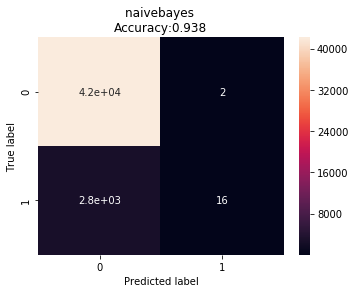

In [21]:
confusion_mc = confusion_matrix(y_test, y_pred1)
df_cm = pd.DataFrame(confusion_mc, 
                     index = [i for i in range(0,2)], columns = [i for i in range(0,2)])

plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm, annot=True)
plt.title('naivebayes \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, 
                                                                       y_pred1)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [22]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [23]:
%%time

y_pred2 = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred2, y_test))
print(classification_report(y_test, y_pred2))

accuracy 0.9277555555555556
             precision    recall  f1-score   support

          0       0.96      0.96      0.96     42186
          1       0.42      0.39      0.40      2814

avg / total       0.93      0.93      0.93     45000

Wall time: 2.59 s


Text(0.5,15,'Predicted label')

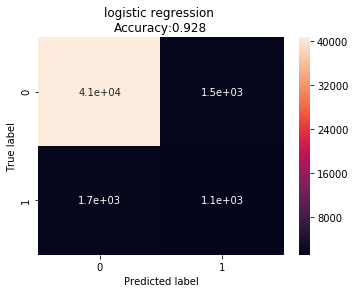

In [48]:
confusion_mc = confusion_matrix(y_test, y_pred2)
df_cm = pd.DataFrame(confusion_mc, 
                     index = [i for i in range(0,2)], columns = [i for i in range(0,2)])

plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm, annot=True)
plt.title('logistic regression \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, 
                                                                       y_pred2)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [44]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [45]:
%%time

y_pred3 = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred3, y_test))
print(classification_report(y_test, y_pred3))

accuracy 0.9374666666666667
             precision    recall  f1-score   support

          0       0.94      1.00      0.97     42186
          1       0.00      0.00      0.00      2814

avg / total       0.88      0.94      0.91     45000

Wall time: 1.94 s


G:\conda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5,15,'Predicted label')

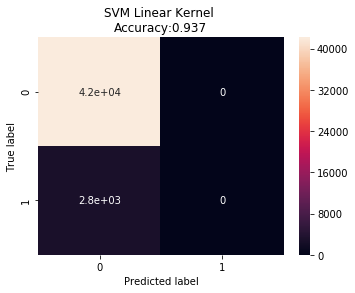

In [49]:
confusion_mc = confusion_matrix(y_test, y_pred3)
df_cm = pd.DataFrame(confusion_mc, 
                     index = [i for i in range(0,2)], columns = [i for i in range(0,2)])

plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm, annot=True)
plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, 
                                                                       y_pred3)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [50]:
logreg1 = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(penalty='l2',max_iter=100,C=1)),
               ])
logreg1.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [51]:
%%time

y_pred4 = logreg1.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred4, y_test))
print(classification_report(y_test, y_pred4))

accuracy 0.9450888888888889
             precision    recall  f1-score   support

          0       0.95      0.99      0.97     42186
          1       0.67      0.24      0.35      2814

avg / total       0.93      0.95      0.93     45000

Wall time: 2.44 s


Text(0.5,15,'Predicted label')

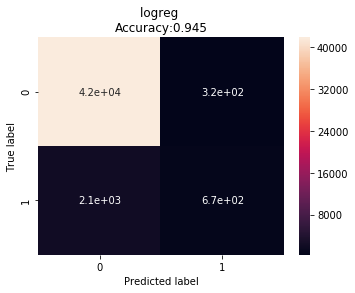

In [52]:
confusion_mc = confusion_matrix(y_test, y_pred4)
df_cm = pd.DataFrame(confusion_mc, 
                     index = [i for i in range(0,2)], columns = [i for i in range(0,2)])

plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm, annot=True)
plt.title('logreg \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, 
                                                                       y_pred4)))
plt.ylabel('True label')
plt.xlabel('Predicted label')